In [1]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
import warnings

warnings.filterwarnings('ignore')

seed = 10
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")

In [2]:
# rna_adata = anndata.concat(
#     [sc.read_csv(f"../../data/scRNAseq/MouseLiver/SCP2045/expression/processed_{sub}.csv.gz").T.copy() for sub in ['s1', 's2', 'c1', 'c2']], join="inner")['s1', 's2', 'c1', 'c2']
samples = ['c1']
rna_adata = anndata.concat(
    [sc.read_csv(f"../../data/scRNAseq/MouseLiver/SCP2045/expression/processed_{sub}.csv.gz").T.copy() for sub in samples], join="inner")
rna_adata.obs = pd.read_csv("../../data/scRNAseq/MouseLiver/SCP2045/metadata/meta_data_manual.csv", index_col=0).loc[rna_adata.obs_names]
rna_adata.obsm['X_umap'] = pd.read_csv("../../data/scRNAseq/MouseLiver/SCP2045/cluster/clustering_manual.csv", index_col=0).loc[rna_adata.obs_names][["X", "Y"]].values.astype(np.float32)
rna_adata.obs['celltype'] = pd.read_csv("../../data/scRNAseq/MouseLiver/SCP2045/cluster/clustering_manual.csv", index_col=0).loc[rna_adata.obs_names]["Category"].values

sc.pp.highly_variable_genes(rna_adata)
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
rna_adata

AnnData object with n_obs × n_vars = 4759 × 4538
    obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_umap'

In [3]:
spa_adata = anndata.concat(
    [sc.read_csv(f"../../data/ST/MouseLiver/SCP2046/expression/processed_{sub}.csv.gz").T.copy() for sub in samples], join="inner")
spa_adata.obs = pd.read_csv("../../data/ST/MouseLiver/SCP2046/metadata/meta_data.csv", index_col=0).loc[spa_adata.obs_names]
spa_adata.obsm['X_umap'] = pd.read_csv("../../data/ST/MouseLiver/SCP2046/cluster/clustering.csv", index_col=0).loc[spa_adata.obs_names][["X", "Y"]].values.astype(np.float32)
spa_adata.obs['celltype'] = pd.read_csv("../../data/ST/MouseLiver/SCP2046/cluster/clustering.csv", index_col=0).loc[spa_adata.obs_names]["Category"].values
spa_adata.obsm['spatial'] = pd.concat([pd.read_csv(f"../../data/ST/MouseLiver/SCP2046/cluster/spatial_{sb}.csv", index_col=0).iloc[1:] for sb in samples], axis=0).loc[spa_adata.obs_names].values.astype(np.float32)
pd.DataFrame(spa_adata.obsm['spatial'], columns=['x','y']).to_csv("../../output/locations/mouseliver.csv", index=False)
sc.pp.filter_genes(spa_adata, min_cells=10)
spa_adata

AnnData object with n_obs × n_vars = 2110 × 14886
    obs: 'biosample_id', 'zones', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype'
    var: 'n_cells'
    obsm: 'X_umap', 'spatial'

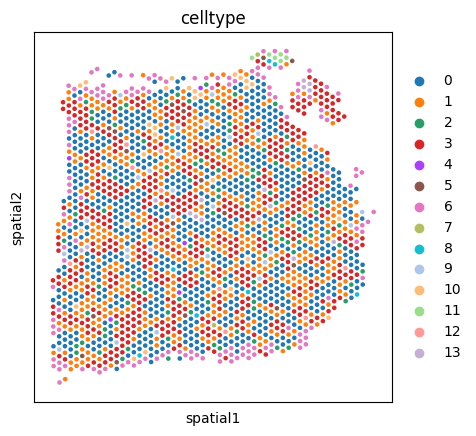

In [4]:
sc.pl.spatial(spa_adata, color='celltype', spot_size=5)

In [5]:
sq.gr.spatial_neighbors(spa_adata, coord_type='grid', n_neighs=6)
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)

In [6]:
classes, ct_list = leiden_cluster(rna_adata, False)
cls_key = 'leiden'
rna_adata.obs[cls_key] = classes
rna_adata, spa_adata


(AnnData object with n_obs × n_vars = 4759 × 4538
     obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype', 'leiden'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'hvg'
     obsm: 'X_umap',
 AnnData object with n_obs × n_vars = 2110 × 14886
     obs: 'biosample_id', 'zones', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype'
     var: 'n_cells'
     uns: 'celltype_colors', 'spatial_neighbors', 'moranI'
     obsm: 'X_umap', 'spatial'
     obsp: 'spatial_connectivities', 'spatial_distances')

In [7]:
raw_spatial_df  = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)
raw_scrna_df    = pd.DataFrame(rna_adata.X, columns=rna_adata.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((2110, 14886), (4759, 4538), (4306,))

In [8]:
spa_adata.uns['moranI']

,I,pval_norm,var_norm,pval_norm_fdr_bh
Hpx,0.575574,0.000000,0.000172,0.000000
Cyp2e1,0.566850,0.000000,0.000172,0.000000
mt-Co1,0.566189,0.000000,0.000172,0.000000
Pck1,0.530227,0.000000,0.000172,0.000000
Saa1,0.521497,0.000000,0.000172,0.000000
...,...,...,...,...
St13,-0.033618,0.005746,0.000172,0.039003
Slc9a6,-0.033977,0.005313,0.000172,0.036925
A930005H10Rik,-0.034397,0.004844,0.000172,0.034694
Snrpd2,-0.036296,0.003151,0.000172,0.025278


In [9]:
spa_shared = spa_adata[:, raw_shared_gene].copy()
rna_shared = rna_adata[:, raw_shared_gene].copy()
raw_spatial_df  = pd.DataFrame(spa_shared.X, columns=spa_shared.var_names)
raw_scrna_df    = pd.DataFrame(rna_shared.X, columns=rna_shared.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((2110, 4306), (4759, 4306), (4306,))

In [10]:
np.random.seed(42)
neg_genes = np.random.choice(spa_shared.var_names[spa_shared.uns['moranI'].loc[raw_shared_gene].pval_norm_fdr_bh.values >= 0.01], 50, replace=False)
pos_genes = np.random.choice(spa_shared.var_names[spa_shared.uns['moranI'].loc[raw_shared_gene].pval_norm_fdr_bh.values < 0.01], 50, replace=False)

train_gene = np.union1d(pos_genes, neg_genes)
test_gene = np.setdiff1d(raw_shared_gene, train_gene)
len(np.unique(train_gene)), len(test_gene)

(100, 4206)

In [11]:
df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_transImp = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)

# for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
print(f"\n==========\nNumber of train genes: {len(train_gene)}, Number of test genes: {len(test_gene)}")

test_spatial_df = raw_spatial_df[test_gene]
spatial_df = raw_spatial_df[train_gene]
scrna_df   = raw_scrna_df

df_transImpSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        n_epochs=2500,
        # clip_max=2,
        mapping_mode='lowrank',
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpSpa)')

df_transImpCls[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        ct_list=ct_list,
        classes=classes,
        n_epochs=2500,
        signature_mode='cluster',
        mapping_mode='full',
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpCls)')

df_transImp[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        n_epochs=2500,
        mapping_mode='lowrank',
        # clip_max=2,
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImp)')

df_transImpClsSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        ct_list=ct_list,
        classes=classes,
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        signature_mode='cluster',
        mapping_mode='full',
        n_epochs=2500,
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "tmp_stvisp", top_k=100, verbose=False, random_seed=seed, device=device)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
print(f'\t\t\t{np.median(corr_res_stplus)} (stPlus)')

df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
print(f'\t\t\t{np.median(corr_res_spaGE)} (spaGE)')

df_tangram_res[test_gene] = Tangram_impute(rna_adata, spa_adata, train_gene, test_gene, device, cls_key)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
print(f'\t\t\t{np.median(corr_res_tangram)} (Tangram)')

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
corr_transImp_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)   

print(np.median(corr_transImpSpa_res), "(TransImpSpa)", 
np.median(corr_transImp_res), "(TransImp)", 
np.median(corr_transImpCls_res), "(TransImpCls)", 
np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
np.median(corr_res_stplus), "(stPlus)", 
np.median(corr_res_spaGE), "(spaGE)",
np.median(corr_res_tangram), "(Tangram)"
)


Number of train genes: 100, Number of test genes: 4206


[TransImp] Epoch: 2500/2500, loss: 0.129803, (IMP) 0.129740, (SPA) 1.0 x 0.000063: 100%|██████████| 2500/2500 [00:10<00:00, 228.79it/s]


Median correlation: 0.020040174675862804 (TransImpSpa)


[TransImp] Epoch: 2500/2500, loss: 0.548034, (IMP) 0.548034, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:05<00:00, 450.43it/s]


Median correlation: 0.05729402212552194 (TransImpCls)


[TransImp] Epoch: 2500/2500, loss: 0.127066, (IMP) 0.127066, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:07<00:00, 350.49it/s]


Median correlation: 0.02058896689316131 (TransImp)


[TransImp] Epoch: 2500/2500, loss: 0.556409, (IMP) 0.550153, (SPA) 1.0 x 0.006256: 100%|██████████| 2500/2500 [00:09<00:00, 275.51it/s]


Median correlation: 0.05323874262408333 (TransImpClsSpa)
			nan (stPlus)


INFO:root:100 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:100 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 100 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


			0.02560985737555348 (spaGE)
Score: 0.491, KL reg: 0.063
Score: 0.713, KL reg: 0.001
Score: 0.714, KL reg: 0.001
Score: 0.714, KL reg: 0.001
Score: 0.714, KL reg: 0.001
Score: 0.714, KL reg: 0.001
Score: 0.714, KL reg: 0.001
Score: 0.714, KL reg: 0.001
Score: 0.714, KL reg: 0.001


INFO:root:Saving results..


Score: 0.714, KL reg: 0.001
			0.043245147026286415 (Tangram)
0.020040174675862804 (TransImpSpa) 0.02058896689316131 (TransImp) 0.05729402212552194 (TransImpCls) 0.05323874262408333 (TransImpClsSpa) nan (stPlus) 0.02560985737555348 (spaGE) 0.043245147026286415 (Tangram)


In [12]:
df_transImp.to_csv('../../output/mouseliverext_singlecell_transImpute.csv')
df_transImpSpa.to_csv('../../output/mouseliverext_singlecell_transImpSpa.csv')
df_transImpCls.to_csv('../../output/mouseliverext_singlecell_transImpCls.csv')
df_transImpClsSpa.to_csv('../../output/mouseliverext_singlecell_transImpClsSpa.csv')
df_spaGE_res.to_csv('../../output/mouseliverext_singlecell_spaGE.csv')
df_stplus_res.to_csv('../../output/mouseliverext_singlecell_stPlus.csv')
df_tangram_res.to_csv('../../output/mouseliverext_singlecell_Tangram.csv')
test_spatial_df.to_csv('../../output/mouseliverext_singlecell_truth.csv')

In [13]:
dict_df = {
        "TransImp":df_transImp[test_gene], 
           "TransImpSpa":df_transImpSpa[test_gene], 
           "TransImpCls":df_transImpCls[test_gene],
           "TransImpClsSpa":df_transImpClsSpa[test_gene],
           "spaGE": df_spaGE_res[test_gene], 
           "stPlus": df_stplus_res[test_gene], 
           "Tangram":df_tangram_res[test_gene]
        }

dict_adata = {name: compute_autocorr(spa_shared[:, test_gene].copy(), df) for name, df in dict_df.items()}


In [14]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import warnings



with open("../../output/mouseliverext_small_train_genes.pkl", 'wb') as outfile:
    pickle.dump((train_gene, test_gene), outfile)

warnings.filterwarnings('ignore')
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
eval_res_path = "../../output/mouseliverext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01


In [15]:
spa_shared

AnnData object with n_obs × n_vars = 2110 × 4306
    obs: 'biosample_id', 'zones', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype'
    var: 'n_cells'
    uns: 'celltype_colors', 'spatial_neighbors', 'moranI'
    obsm: 'X_umap', 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [16]:
if is_reeval:
    spa_adata = spa_shared[:, test_gene].copy()
    df_spa = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)

    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'is_sig':{}, 'I':{}, 'spatialDE_stats':{}, 'spatialDE_qvals':{}}
    for method  in tqdm(['stPlus', 'spaGE', 'Tangram', 'TransImp', 'TransImpSpa', 'TransImpCls', 'TransImpClsSpa']):
   
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        imp_adata = dict_adata[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=6)
        sq.gr.spatial_autocorr(
            imp_adata,
            n_jobs=20,
            mode='moran',
        )

        if not is_reeval:
            continue

       
        is_sig = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['is_sig'][method] = pd.Series(is_sig, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)


100%|██████████| 7/7 [00:29<00:00,  4.25s/it]


In [17]:
np.unique(spa_adata.uns['moranI'].pval_norm_fdr_bh < .01, return_counts=True)

(array([False,  True]), array([13464,  1422]))

In [18]:

df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_issig     = pd.DataFrame(dict(sorted(eval_res['is_sig'].items())))
df_spatialDE_stats = pd.DataFrame(dict(sorted(eval_res['spatialDE_stats'].items())))
df_spatialDE_pvals = pd.DataFrame(dict(sorted(eval_res['spatialDE_qvals'].items())))

df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_issig['truth'] = spa_adata.uns['moranI'].loc[df_issig.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_issig.index.values,:].I

imp_adatas = dict(sorted(imp_adatas.items()))
df_issig

,Tangram,TransImp,TransImpCls,TransImpClsSpa,TransImpSpa,spaGE,stPlus,truth
0610005C13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,4.589917e-01
0610031O16Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,5.035684e-02
1110019D14Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,3.474314e-01
1190005I06Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.297693e-06
1300002E11Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,3.999578e-01
...,...,...,...,...,...,...,...,...
Zyg11b,0.210174,0.032503,0.374050,0.006288,0.023069,0.047592,NaN,3.915908e-01
mt-Nd1,0.205132,0.021879,0.367985,0.005970,0.019149,0.042740,NaN,0.000000e+00
mt-Nd2,0.201024,0.021124,0.361366,0.005701,0.017091,0.041210,NaN,0.000000e+00
mt-Nd5,0.177757,0.020363,0.361366,0.003645,0.017050,0.023256,NaN,4.408853e-10


(Tangram) Valid genes: 3307/4206
Tangram
FPR: 0.822776
(TransImp) Valid genes: 3307/4206
TransImp
FPR: 0.394727
(TransImpSpa) Valid genes: 3307/4206
TransImpSpa
FPR: 0.386672
(spaGE) Valid genes: 3307/4206
spaGE
FPR: 0.667887
(stPlus) Valid genes: 2838/4206
stPlus
FPR: 0.000000


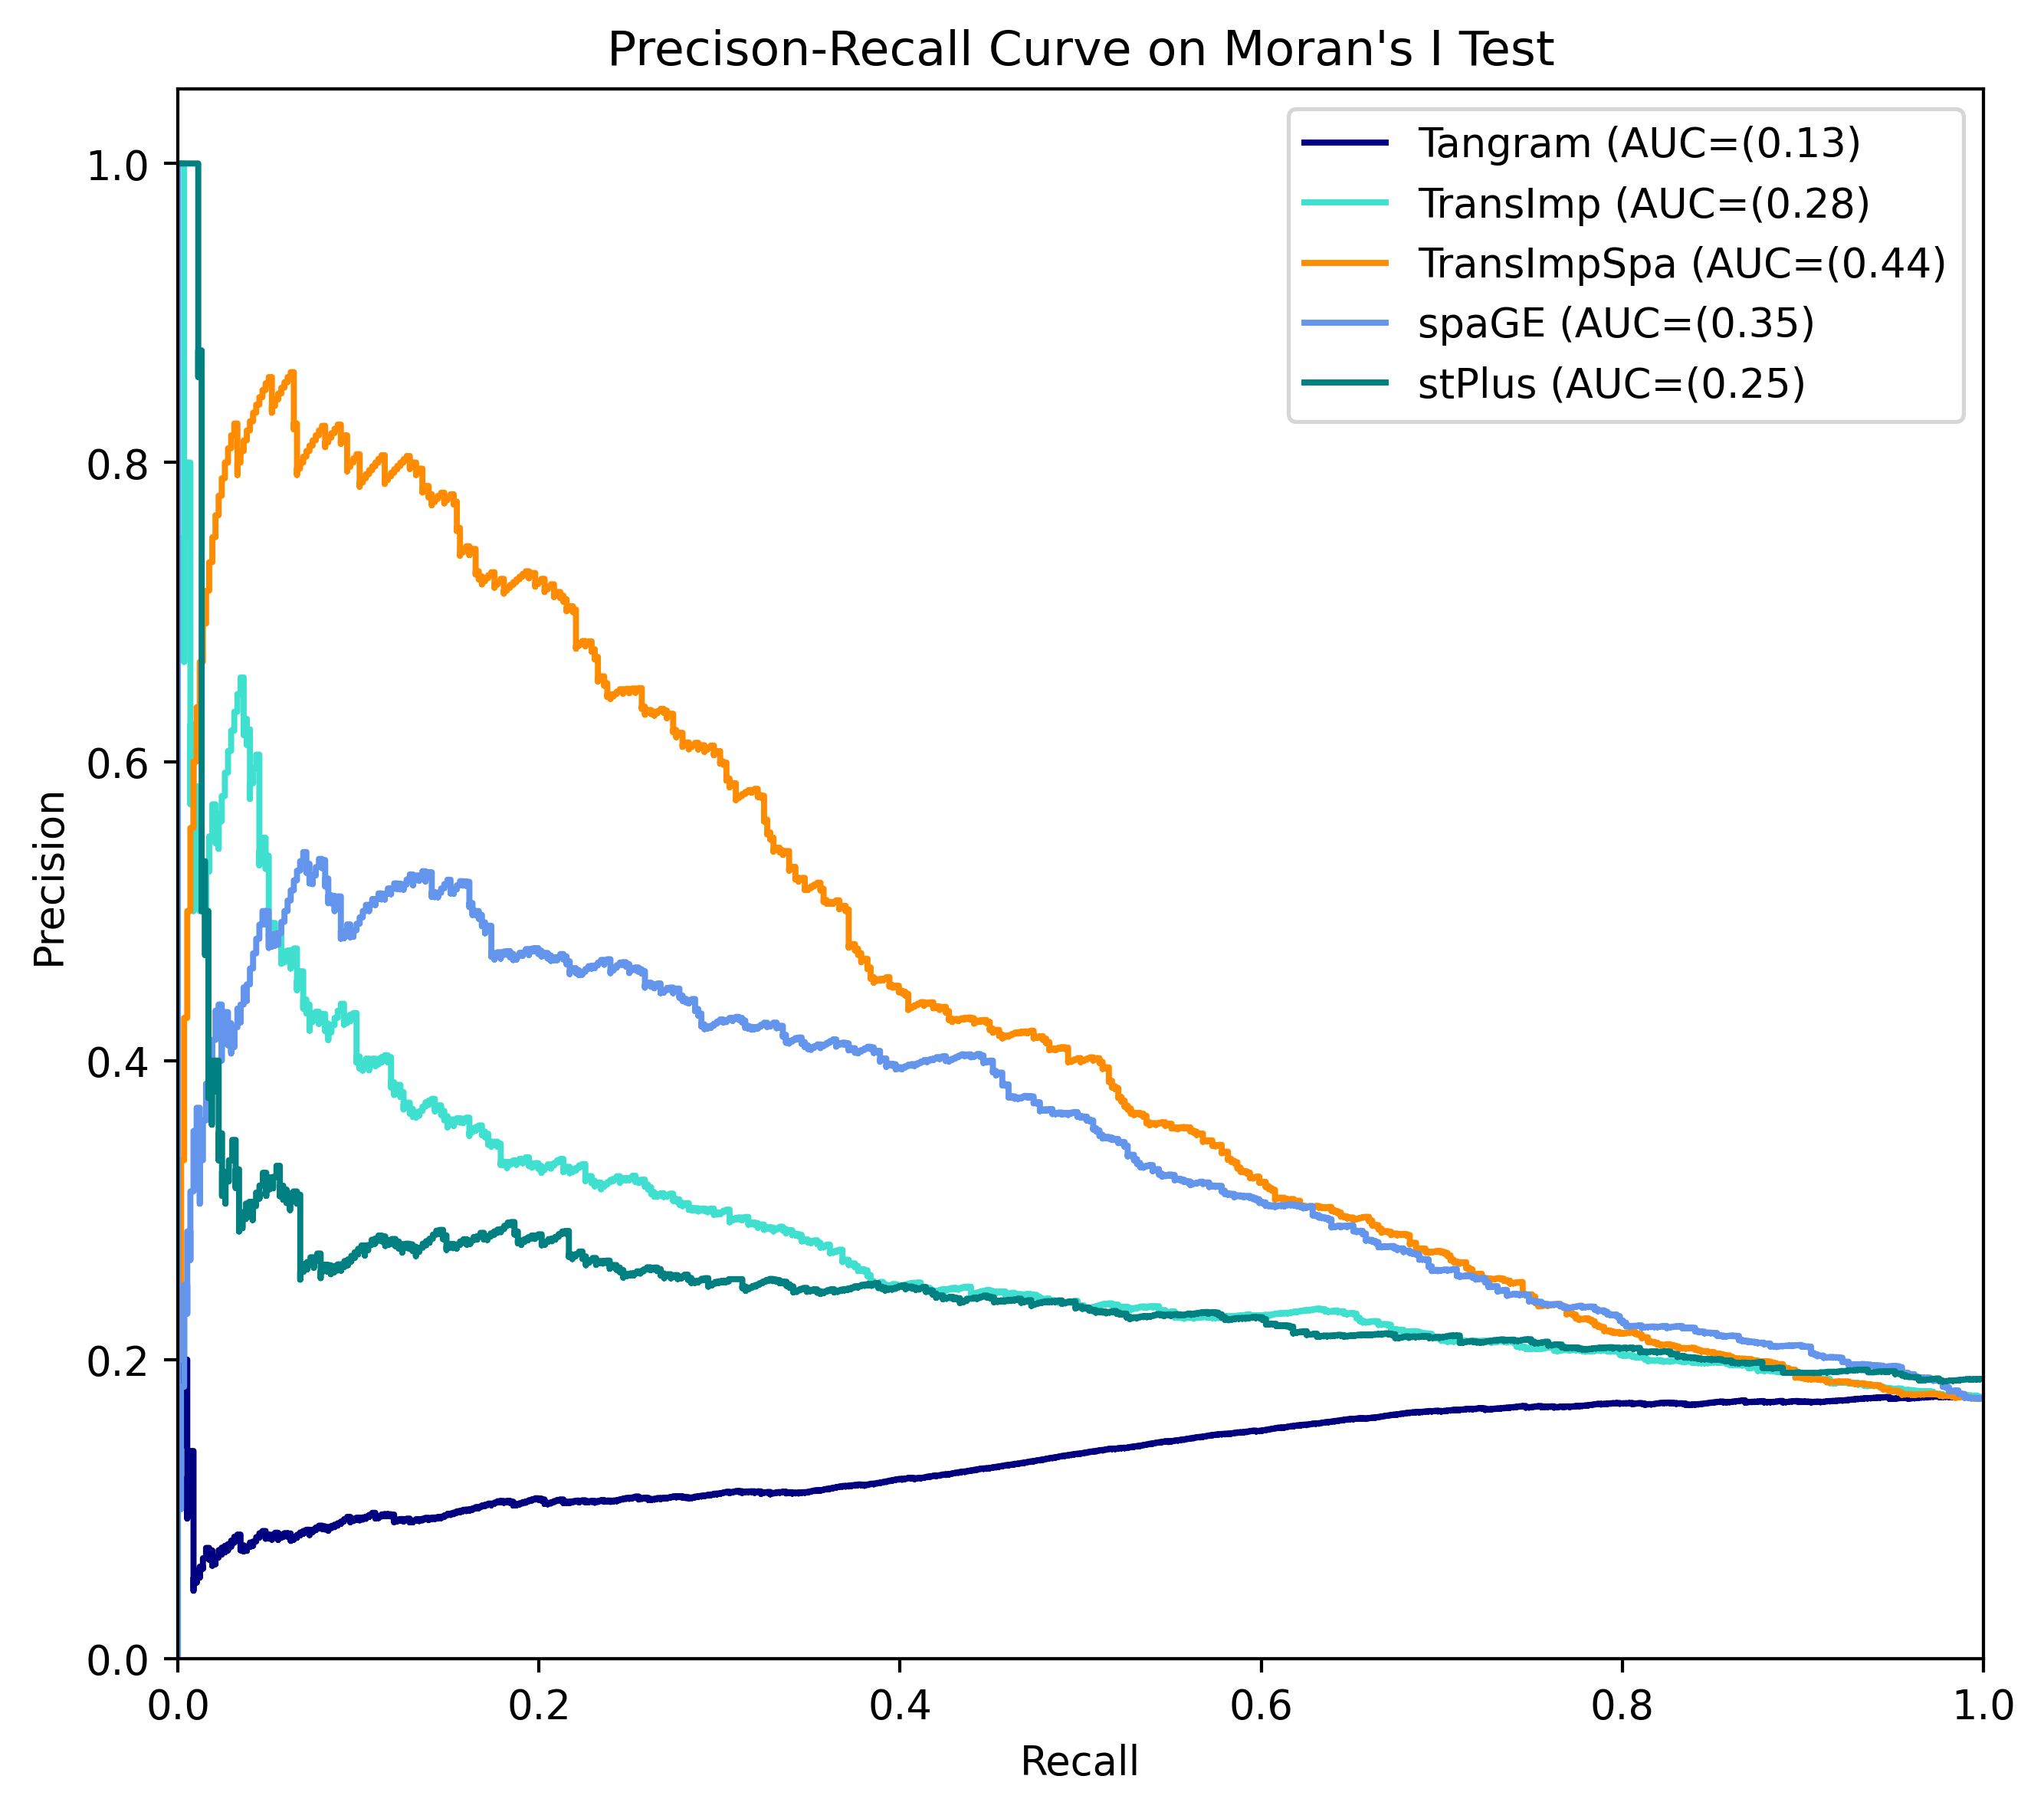

In [19]:
from sklearn import metrics
from matplotlib import pyplot as plt

idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred

    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    
    prec, rec, thresholds  = metrics.precision_recall_curve(y < thred, I, pos_label=1)
    
    auc_score = metrics.auc(rec, prec)
    
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({auc_score:.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on Moran's I Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 3307/4206
Tangram
FPR: 0.822776
(TransImp) Valid genes: 3307/4206
TransImp
FPR: 0.394727
(TransImpSpa) Valid genes: 3307/4206
TransImpSpa
FPR: 0.386672
(spaGE) Valid genes: 3307/4206
spaGE
FPR: 0.667887
(stPlus) Valid genes: 2838/4206
stPlus
FPR: 0.000000


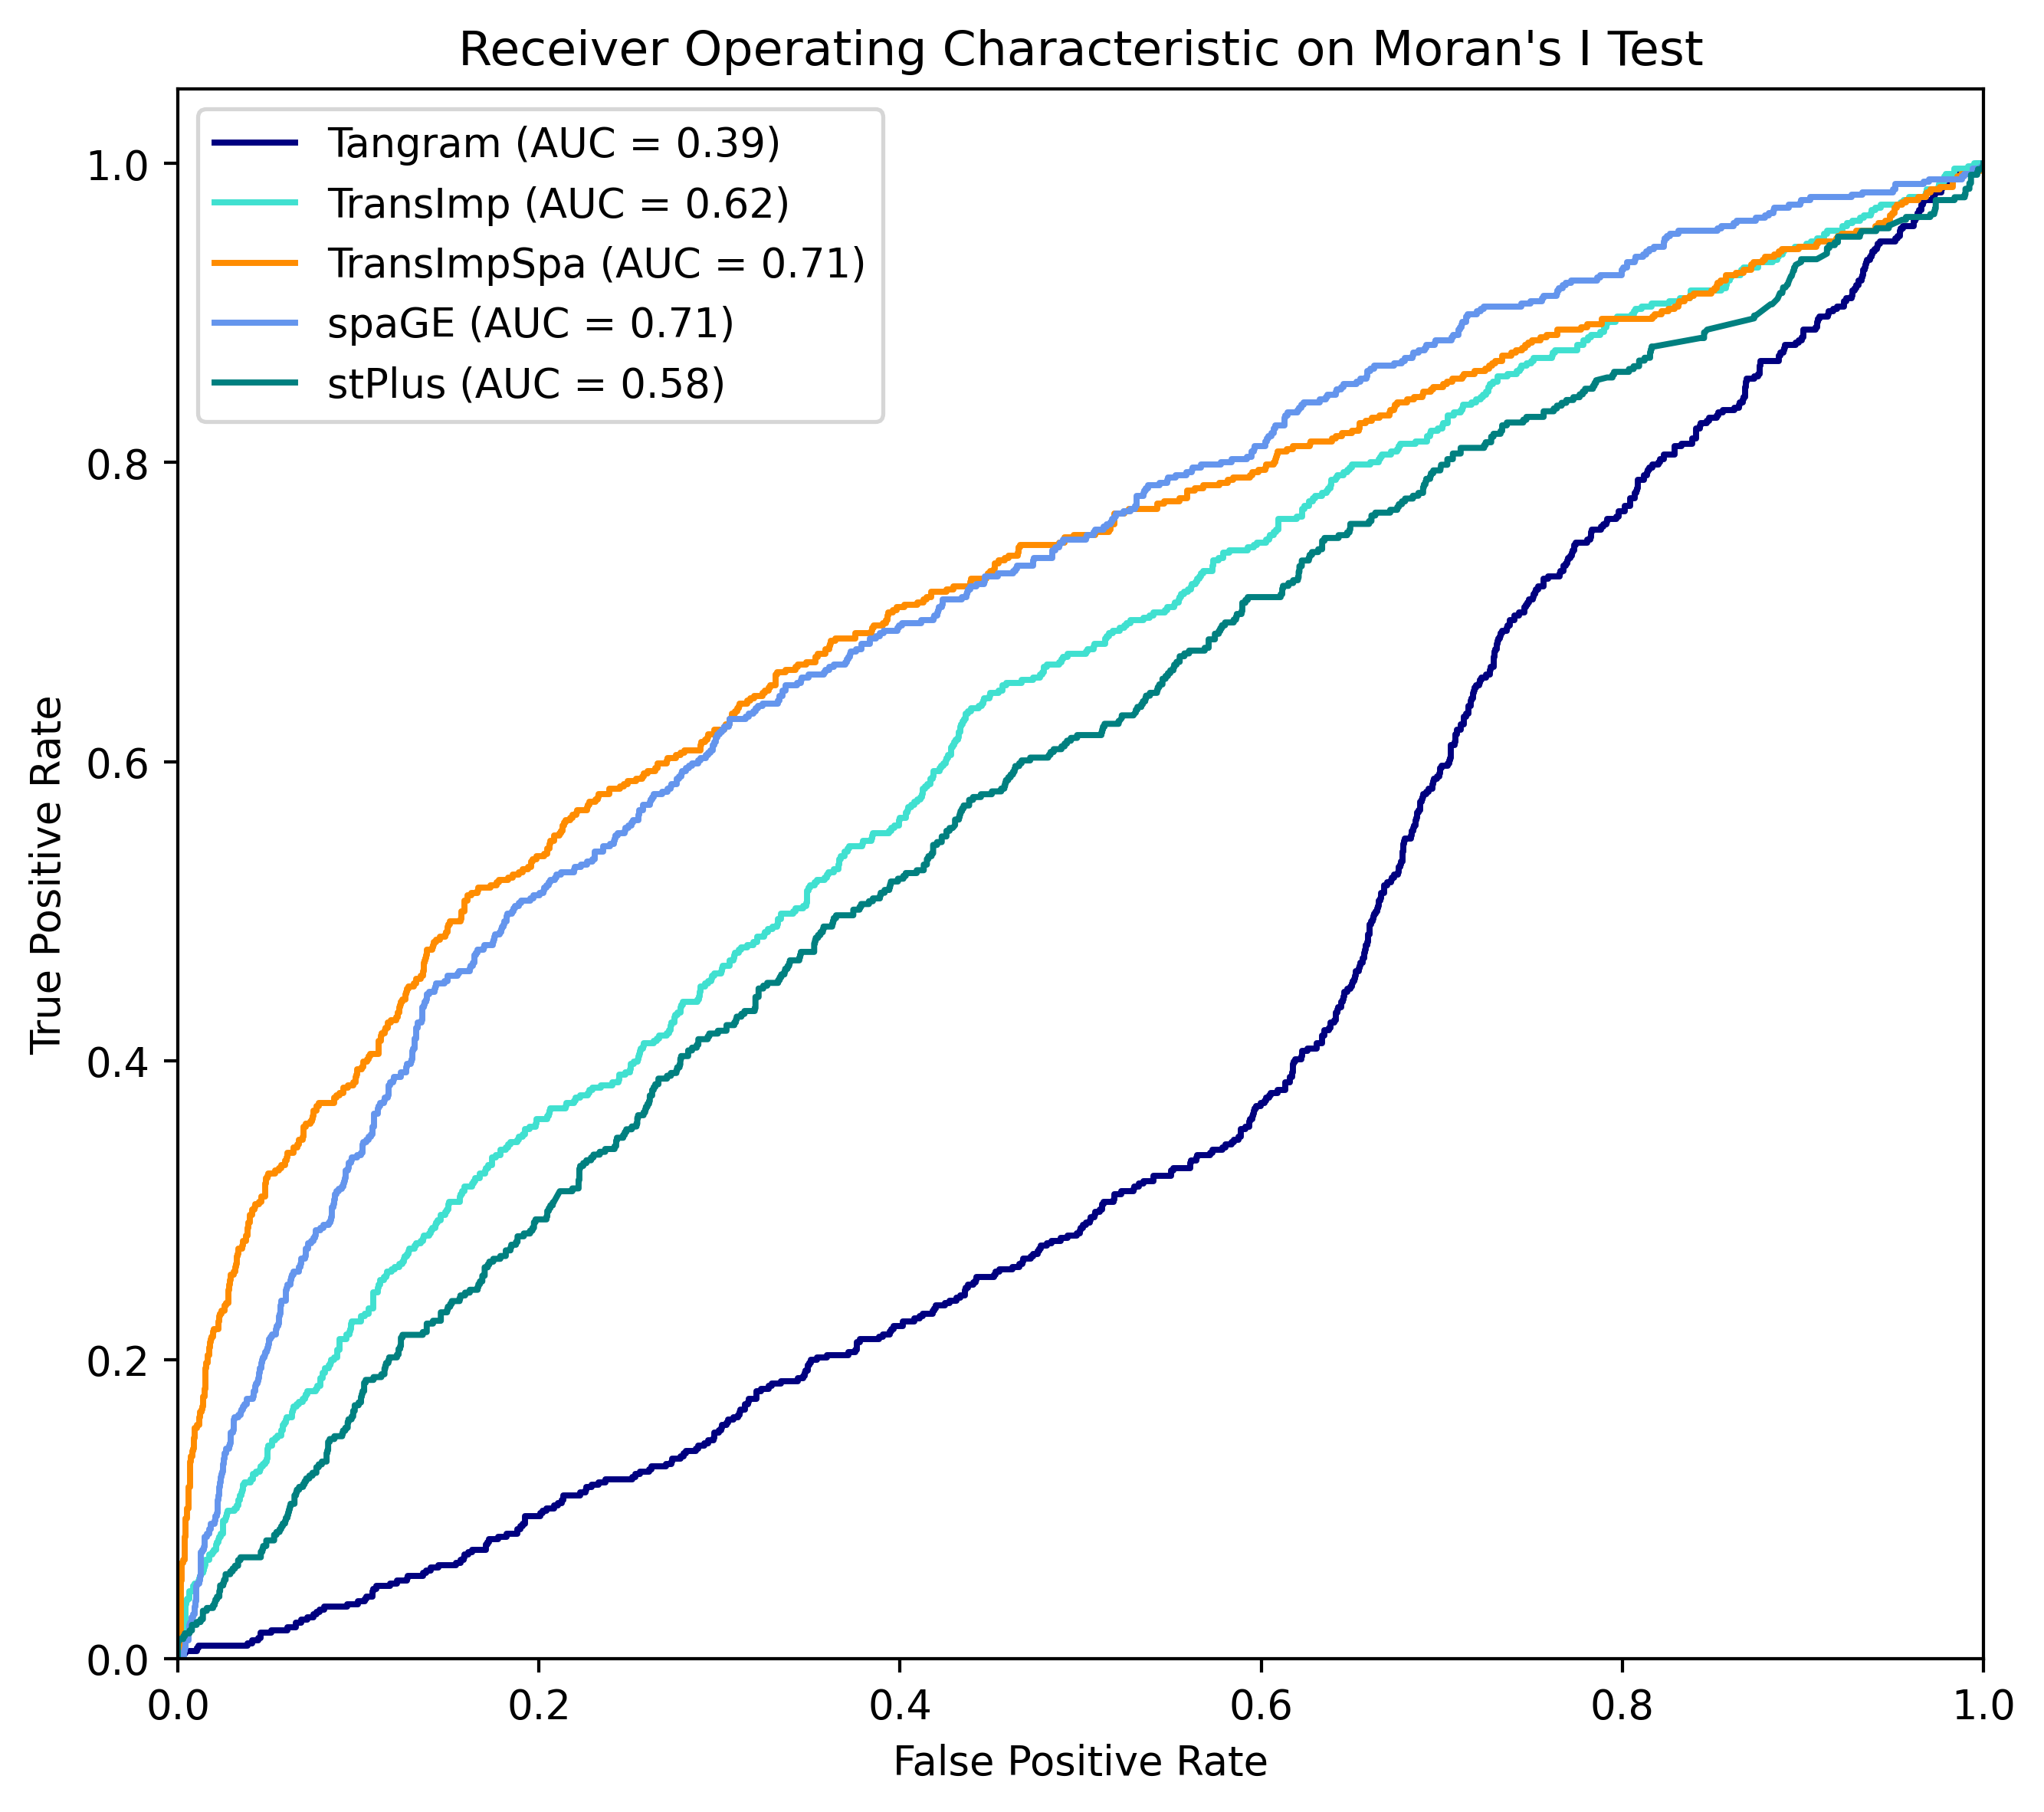

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

In [20]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2
fprs = []
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue

    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0) 
    
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        fprs.append({"Method": method, 'False Positive Rate':cm[0][1]/(cm[0][1] + cm[0][0]), "Test": "Moran's I"})
        idx += 1
    else:
        continue
    fpr, tpr, thresholds  = metrics.roc_curve(y < thred, I, pos_label=1)
    
    auc_score = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp.plot(ax=ax, name=f"{method} (AUC = {auc_score:.2f})", color=color[idx])
    


ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on Moran's I Test")
ax.legend(loc="best")
plt.show()


(Tangram) Valid genes: 3307/4206
Tangram
FPR: 0.822776
prec: 0.1796276013143483, recl: 0.8541666666666666,  F1: 0.2968325791855203
(TransImp) Valid genes: 3307/4206
TransImp
FPR: 0.394727
prec: 0.19492158327109785, recl: 0.453125,  F1: 0.2725848563968668
(TransImpCls) Valid genes: 3307/4206
TransImpCls
FPR: 0.927133
prec: 0.17872202400259488, recl: 0.9565972222222222,  F1: 0.30117518447663294
(TransImpClsSpa) Valid genes: 3307/4206
TransImpClsSpa
FPR: 0.564628
prec: 0.19224724986904138, recl: 0.6371527777777778,  F1: 0.29537223340040236
(TransImpSpa) Valid genes: 3307/4206
TransImpSpa
FPR: 0.386672
prec: 0.19389312977099238, recl: 0.4409722222222222,  F1: 0.26935312831389185
(spaGE) Valid genes: 3307/4206
spaGE
FPR: 0.667887
prec: 0.18462226195797943, recl: 0.7170138888888888,  F1: 0.29363668681123356
(stPlus) Valid genes: 2838/4206
stPlus
FPR: 0.000000
prec: 0.0, recl: 0.0,  F1: 0.0


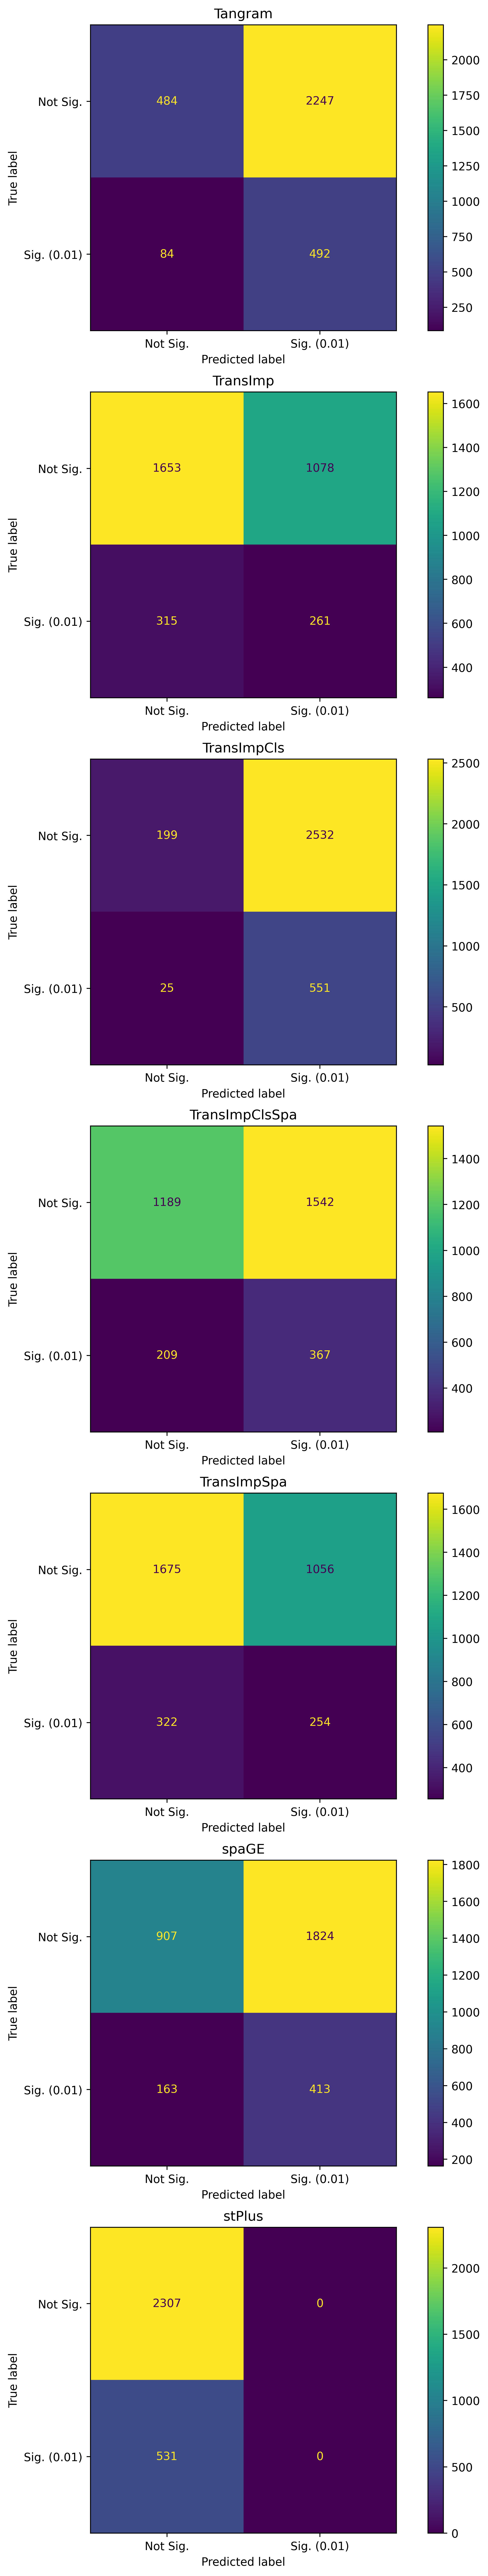

In [21]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    # if method == "stPlus": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    # else:
        # continue
    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0) # & (df_issig.truth.values == 0)
    # sel = sel & (spa_adata[:, df_I.index.values].uns['moranI'].pval_norm_fdr_bh.values < thred)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    # print("precision ", metrics.precision_score(y < thred, preds))
    # print("recall", metrics.recall_score(y < thred , preds))
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(y < thred, preds)}, recl: {metrics.recall_score(y < thred, preds)},  F1: {metrics.f1_score(y < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [22]:
# !Rscript sparkX.r
!/mnt/chenqiao/nfs_share/software/anaconda3/envs/r-environment/bin/Rscript sparkX.r mouseliver

[1] "transImpute"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 2110 
## number of total genes: 4206 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5
[1] "transImpSpa"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 2110 
## number of total genes: 4206 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
##

In [23]:
methods = ["truth", "transImpute", "transImpSpa", "transImpCls", "transImpClsSpa", "spaGE", "stPlus", "Tangram"]
dict_sparkx_cmbpvals = {}
dict_sparkx_adjpvals = {}
ca_genes = None
name_mapping = {"transImpute":"TransImp", "transImpSpa":"TransImpSpa", "transImpCls":"TransImpCls", "transImpClsSpa":"TransImpClsSpa"}
for md in methods:
    df = pd.read_csv(f"../../output/sparkx_mouseliver_{md}.csv", header=0, index_col=0)
    if ca_genes is None:
        ca_genes = df.index.values
    
    if md in name_mapping:
        md = name_mapping[md]
    
    diff_genes = np.setdiff1d(ca_genes, df.index.values)
    if len(diff_genes) > 0:
        df = df.append(pd.DataFrame(np.ones((len(diff_genes), df.shape[1])), index=diff_genes, columns=df.columns))
        
    dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
    dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)
df_sparkx_cmbpvals, df_sparkx_adjpvals
    

(                        truth  TransImp  TransImpSpa   TransImpCls  \
 X0610005C13Rik   2.658968e-02  0.002608     0.000100  5.274781e-11   
 X0610031O16Rik   1.132360e-02  0.706934     0.000303  2.153611e-11   
 X1110019D14Rik   3.337917e-01  0.300540     0.012062  1.056400e-06   
 X1190005I06Rik   1.630957e-03  0.000275     0.017415  9.791057e-12   
 X1300002E11Rik   8.576332e-01  0.003055     0.001047  3.253663e-09   
 ...                       ...       ...          ...           ...   
 Zyg11b           2.934802e-01  0.013840     0.014100  5.537792e-13   
 mt.Nd1           2.152494e-46  0.000003     0.000083  4.687584e-12   
 mt.Nd2          1.145121e-102  0.000108     0.002651  2.213552e-11   
 mt.Nd5           1.670276e-18  0.000177     0.001465  5.312417e-13   
 mt.Nd6           5.703477e-02  0.000959     0.020719  1.073319e-11   
 
                 TransImpClsSpa     spaGE    stPlus       Tangram  
 X0610005C13Rik    6.098089e-11  0.001338  0.291200  6.297304e-03  
 X0610031O

(Tangram) Valid genes: 4206/4206
Tangram
FPR: 0.570843
(TransImp) Valid genes: 4206/4206
TransImp
FPR: 0.065078
(TransImpSpa) Valid genes: 4206/4206
TransImpSpa
FPR: 0.131694
(spaGE) Valid genes: 4206/4206
spaGE
FPR: 0.031002
(stPlus) Valid genes: 4206/4206
stPlus
FPR: 0.104791


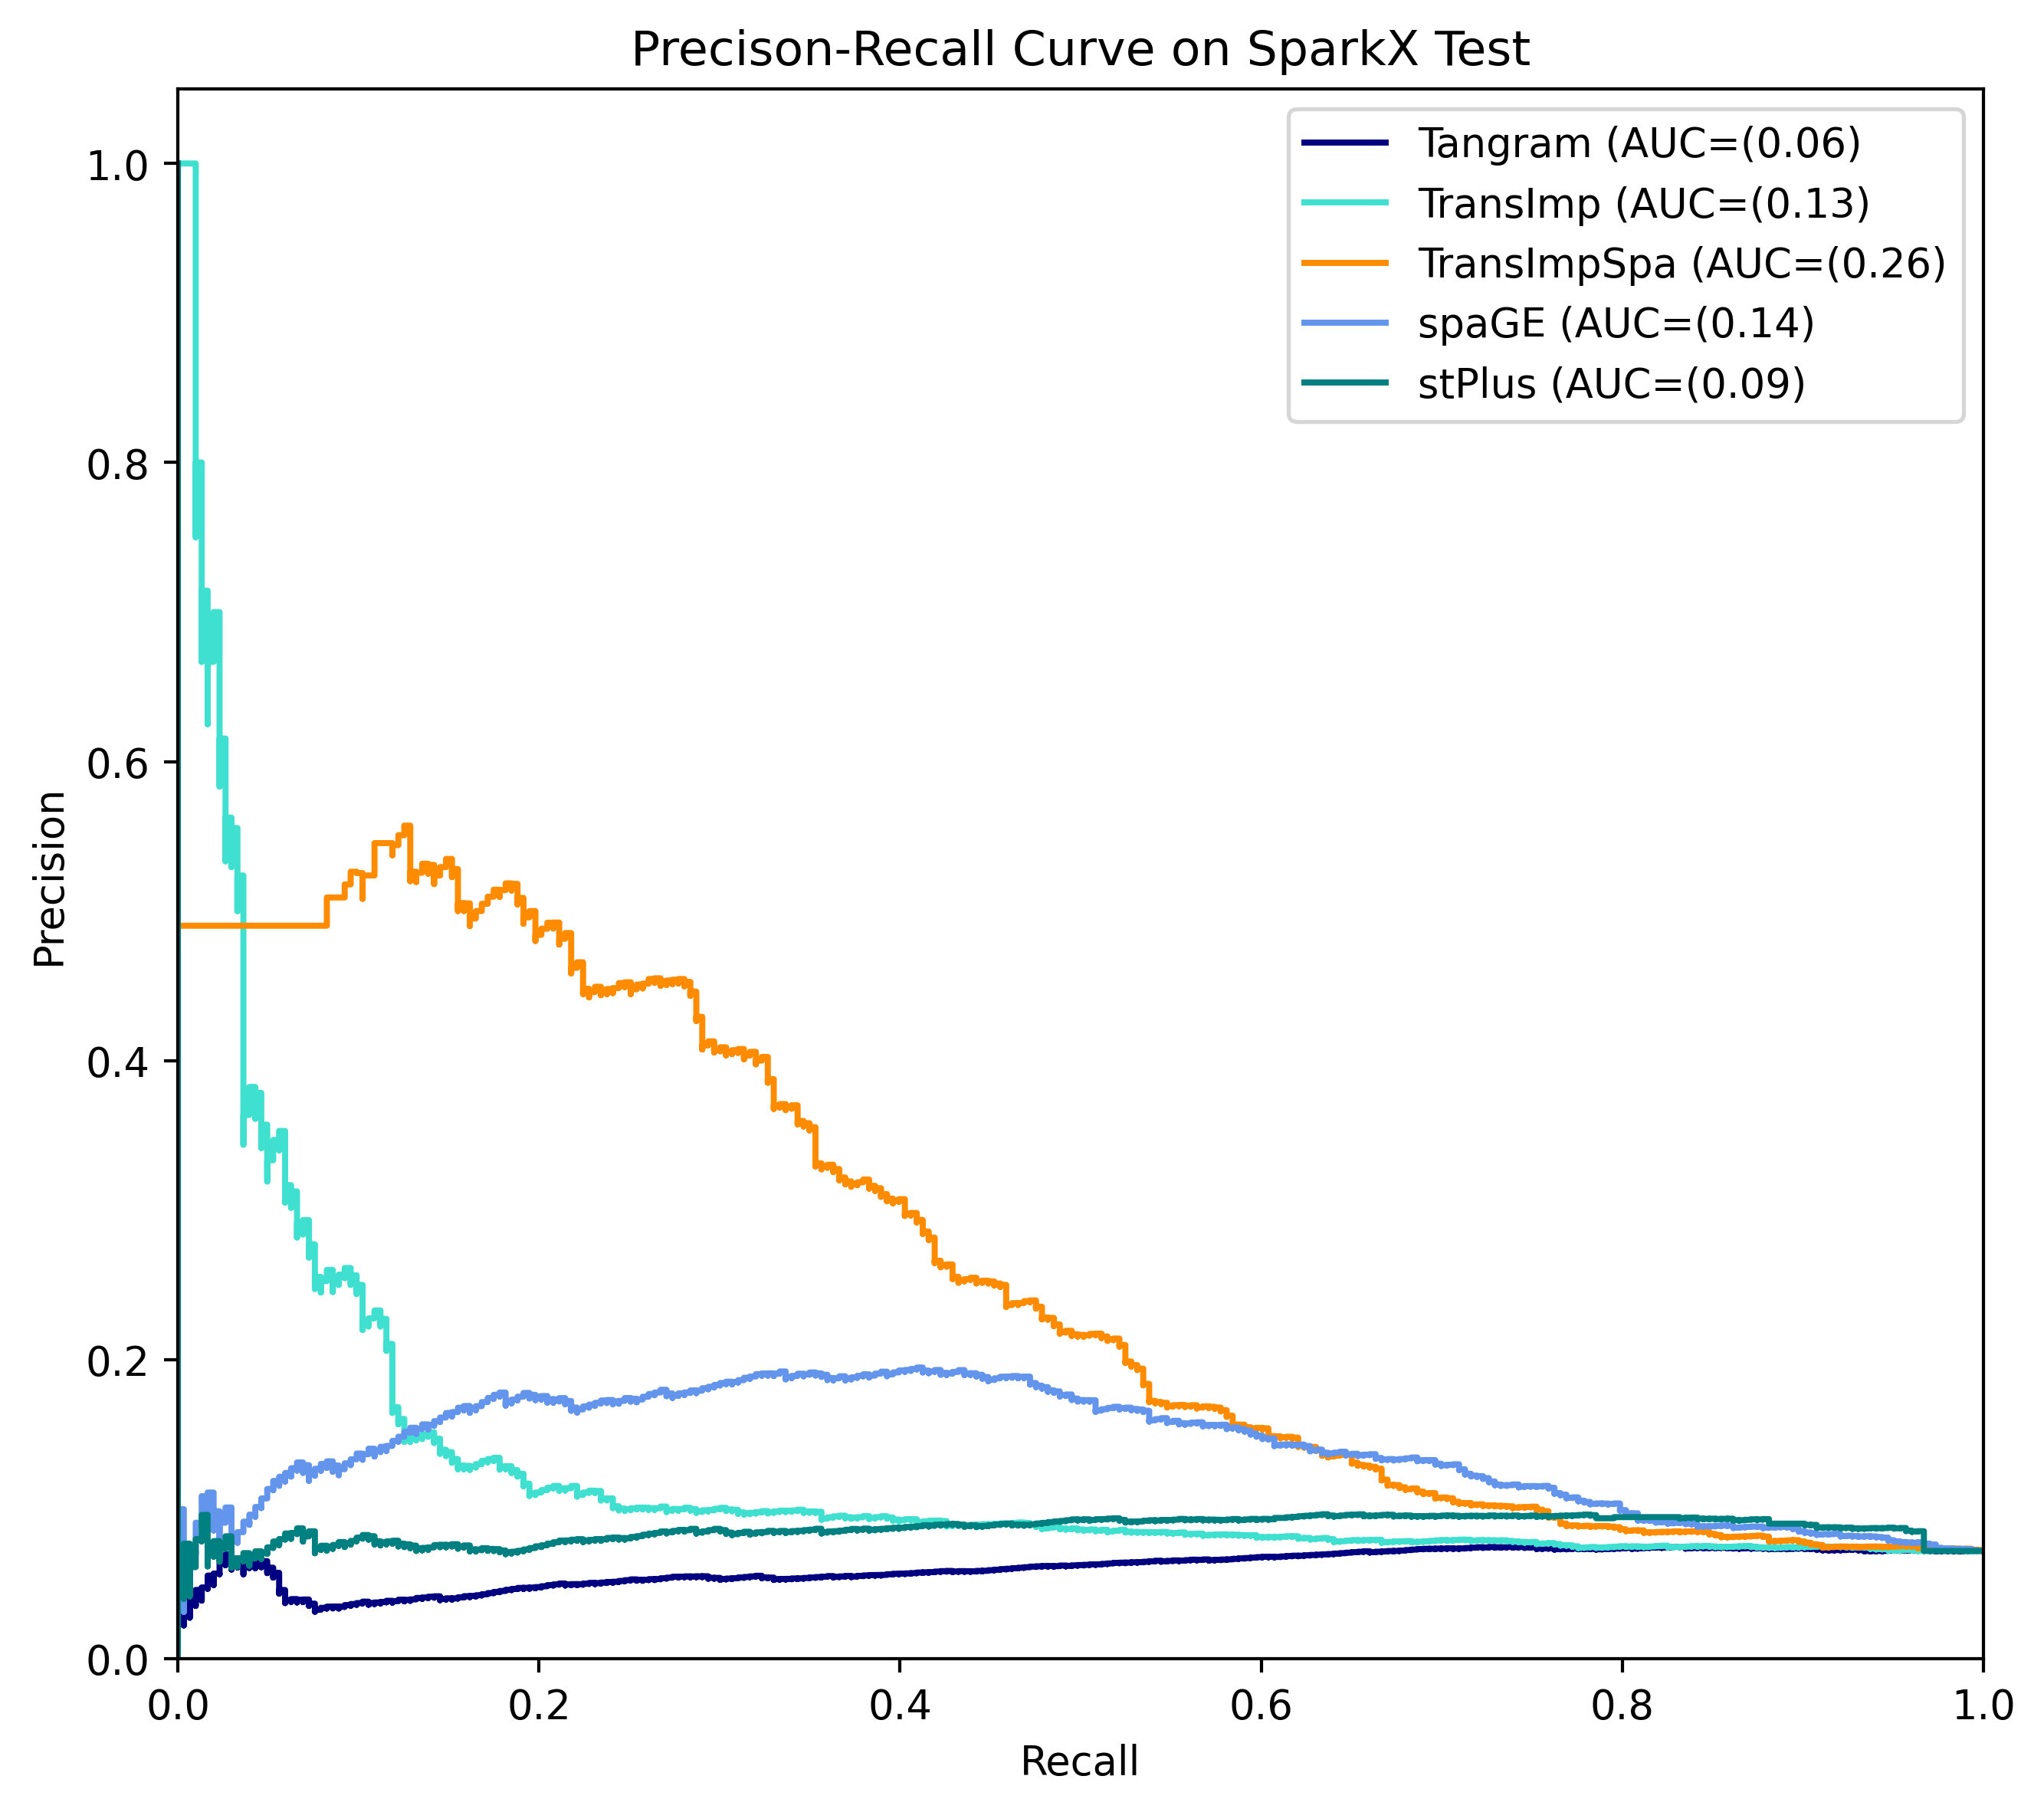

In [24]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_adjpvals[method][sel].values
    score = 1 - df_sparkx_cmbpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
    
        
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
        
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 4206/4206
Tangram
FPR: 0.570843
(TransImp) Valid genes: 4206/4206
TransImp
FPR: 0.065078
(TransImpSpa) Valid genes: 4206/4206
TransImpSpa
FPR: 0.131694
(spaGE) Valid genes: 4206/4206
spaGE
FPR: 0.031002
(stPlus) Valid genes: 4206/4206
stPlus
FPR: 0.104791


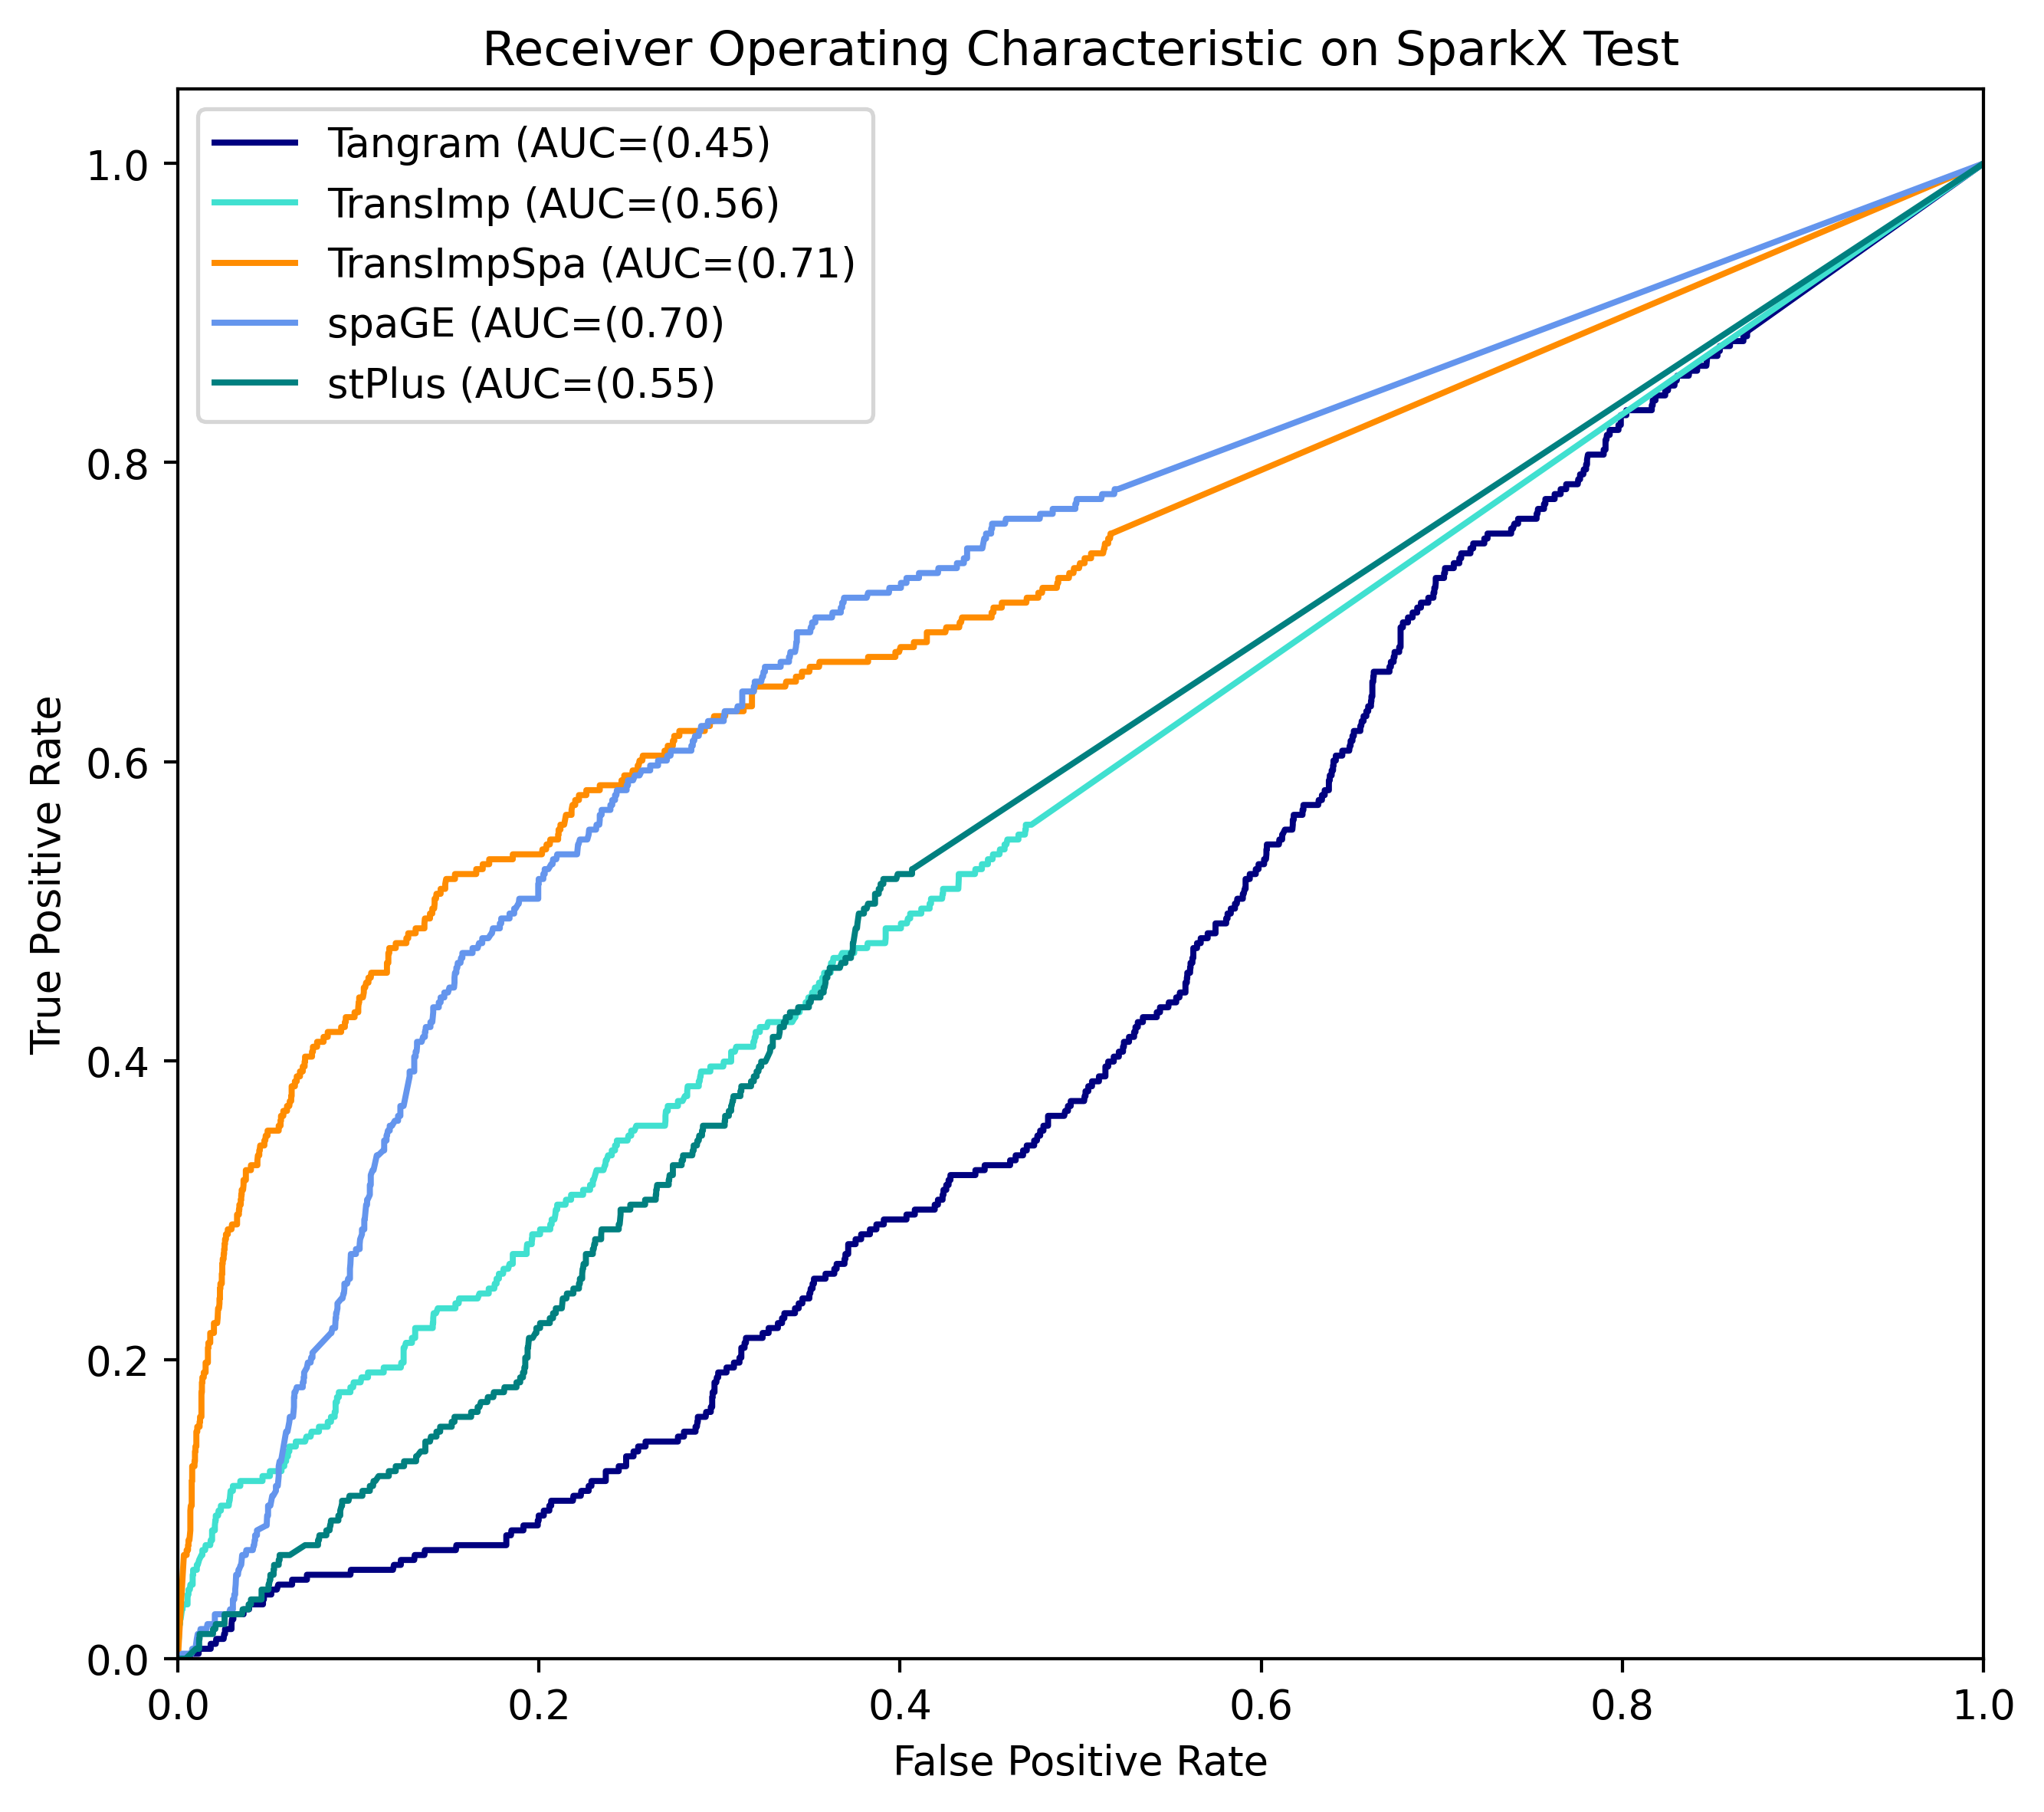

In [25]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 4206/4206
Tangram
FPR: 0.570843
prec: 0.061894736842105266, recl: 0.48514851485148514,  F1: 0.10978342046303212
(TransImp) Valid genes: 4206/4206
TransImp
FPR: 0.065078
prec: 0.1447811447811448, recl: 0.1419141914191419,  F1: 0.14333333333333334
(TransImpCls) Valid genes: 4206/4206
TransImpCls
FPR: 0.834486
prec: 0.08072255151001975, recl: 0.9438943894389439,  F1: 0.1487259490379615
(TransImpClsSpa) Valid genes: 4206/4206
TransImpClsSpa
FPR: 0.684602
prec: 0.09146548792927575, recl: 0.8877887788778878,  F1: 0.1658446362515413
(TransImpSpa) Valid genes: 4206/4206
TransImpSpa
FPR: 0.131694
prec: 0.22356495468277945, recl: 0.4884488448844885,  F1: 0.3067357512953368
(spaGE) Valid genes: 4206/4206
spaGE
FPR: 0.031002
prec: 0.09022556390977443, recl: 0.039603960396039604,  F1: 0.055045871559633024
(stPlus) Valid genes: 4206/4206
stPlus
FPR: 0.104791
prec: 0.07674943566591422, recl: 0.11221122112211221,  F1: 0.09115281501340482


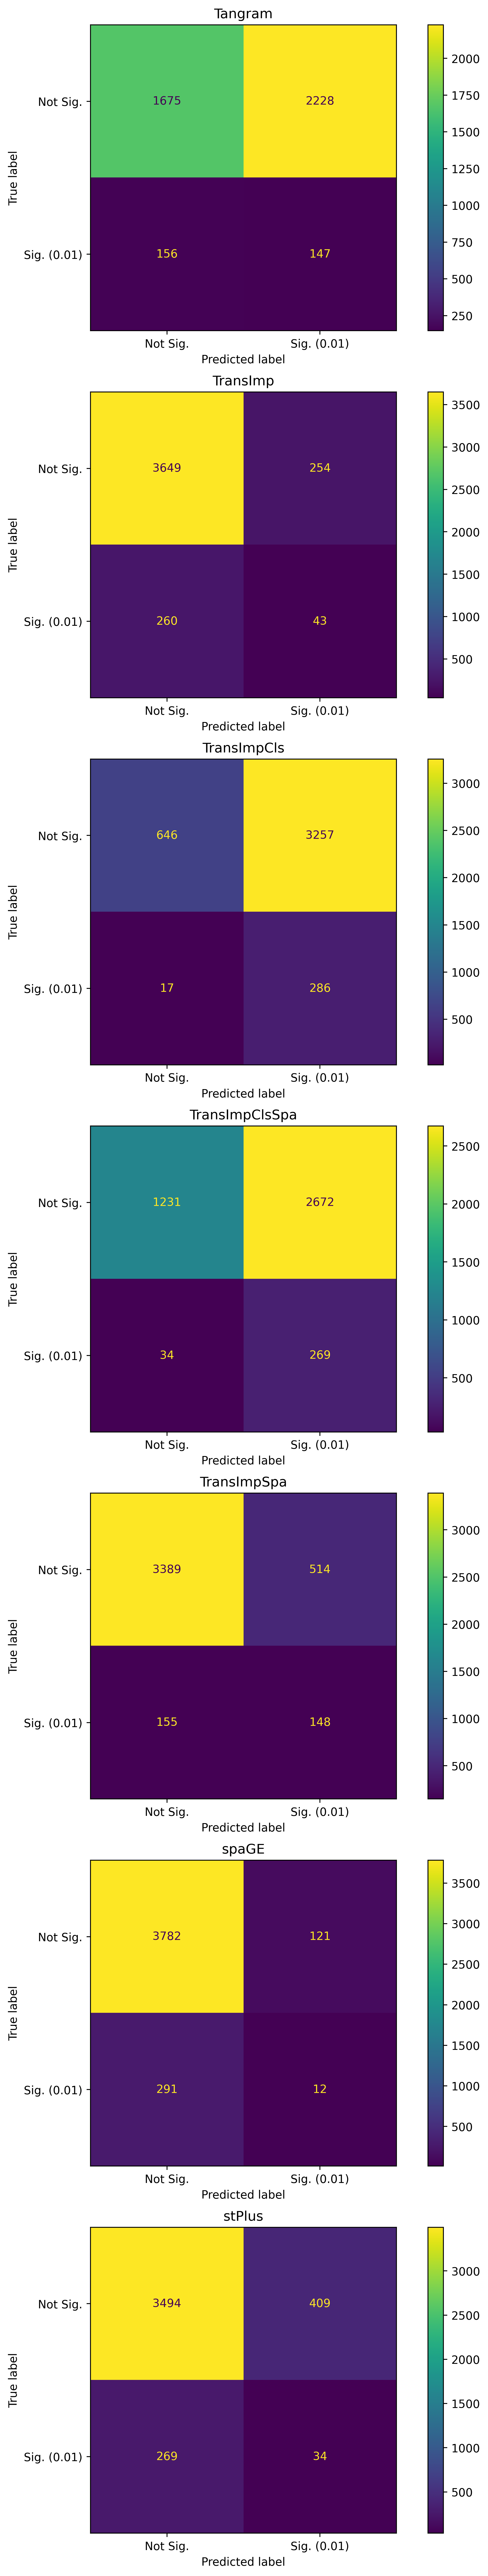

In [26]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    # if method == "stPlus": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()